# Data analysis with Neo4j and python for RESIDE_IN data

## Imports

In [1]:
from py2neo import Graph, Database

In [2]:
from neo4j import GraphDatabase

In [3]:
from tabulate import tabulate

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

In [5]:
import seaborn as sns
sns.set();
sns.color_palette("colorblind");

In [6]:
%matplotlib inline

## Conect to database:

In [7]:
uri = 'bolt://neo4j-hdx:7687'

## Py2neo

In [8]:
default_db = Database(uri, auth=("neo4j", "test"))

In [9]:
default_db.name

'graphHDX.db'

Default graph in the database:

In [10]:
default_db.default_graph.name

'data'

Instanciate a Graph object conecting to the default graph 'data' exposed in 'graphHDX.db':

In [11]:
graph = Graph(uri, auth=("neo4j", "test"))

In [12]:
graph.database.name

'graphHDX.db'

Get the number of nodes in the graph:

In [13]:
len(graph.nodes)

7376

Get the number of relationship in the graph:

In [14]:
len(graph.relationships)

124501

Explore the Schema of the graph:

 - Nodes

In [15]:
graph.schema.node_labels

frozenset({'Country', 'CountryYear'})

 - Relationships

In [16]:
rel_types = graph.schema.relationship_types

In [17]:
len(rel_types)

59

In [18]:
list(rel_types)[0:5]

['1967', '1983', '1981', '2006', '1962']

Relationship between CountryYear nodes:

In [19]:
[rel for rel in graph.schema.relationship_types if not rel.isdigit()]

['RESIDE_IN']

Get all years with available data from the relationship_types:

In [20]:
years_list = [rel for rel in graph.schema.relationship_types if rel.isdigit()]
years_list.sort()

In [21]:
years_list[0:5]

['1960', '1961', '1962', '1963', '1964']

Get all possible countries with all years that have data available:

In [22]:
nodes_country_year_list = list(graph.nodes.match("CountryYear"))

The total number of the combinations between countries and years with data available is:

In [23]:
len(nodes_country_year_list)

7154

Let's define a funtion to print in table format all countries with available World Bank Indicators for a given year:

In [24]:
def print_table_country_indicators_given_year(year, nodes_country_year):
    
    print(tabulate([{ key : element[key] for key in ["year", 
                                                     "country",
                                                     "population",
                                                     "pop_growth_percentage", 
                                                     "urban_pop_percentage", 
                                                     "int_migrant_stock" ] } for element in nodes_country_year if element["year"] == year], 
                       headers="keys",
                       stralign='center',
                       floatfmt='.0f'))

In [25]:
print_table_country_indicators_given_year(2017, nodes_country_year_list)

  year                   country                     population    pop_growth_percentage    urban_pop_percentage   int_migrant_stock
------  -----------------------------------------  ------------  -----------------------  ----------------------  -------------------
  2017                 Netherlands                     17132854                        1                      91
  2017             Antigua and Barbuda                   102012                        1                      25
  2017                 Cabo Verde                        546388                        1                      65
  2017                  Mauritius                       1264613                        0                      41
  2017                  Ethiopia                      104957440                        2                      20
  2017                   Algeria                       41318144                        2                      72
  2017                   Rwanda                        

In [26]:
print_table_country_indicators_given_year(2013, nodes_country_year_list)

  year                   country                     population    pop_growth_percentage    urban_pop_percentage   int_migrant_stock
------  -----------------------------------------  ------------  -----------------------  ----------------------  -------------------
  2013                 Netherlands                     16804432                        0                      89
  2013             Antigua and Barbuda                    97824                        1                      25
  2013                 Cabo Verde                        520106                        1                      63
  2013                  Mauritius                       1258653                        0                      41
  2013                  Ethiopia                       94887728                        3                      19
  2013                   Algeria                       38338560                        2                      70
  2013                   Rwanda                        

## Neo4j driver

Conect to the database using the driver class GraphDatabase 

In [27]:
driver = GraphDatabase.driver(uri, auth=("neo4j", "test"))

### Yearly evolution of the total number of population of concern

Define a query that calculates the sum of all population of concern in the world for a given year:

In [28]:
def total_pop_concern_given_year(tx, year):
    return tx.run("MATCH (a:CountryYear)-[r:RESIDE_IN]->(b:CountryYear) "
                        "WHERE a.year={0} AND b.year={0} " 
                         "RETURN a.year as year, sum(r.affected_total) as affectedTotal".format(year)) 

Iterate t

In [29]:
with driver.session() as session:
    out_total_pop = []
    for year in years_list[0::1]:
        [out_total_pop.append(element) for element in session.read_transaction(total_pop_concern_given_year, year).data()]

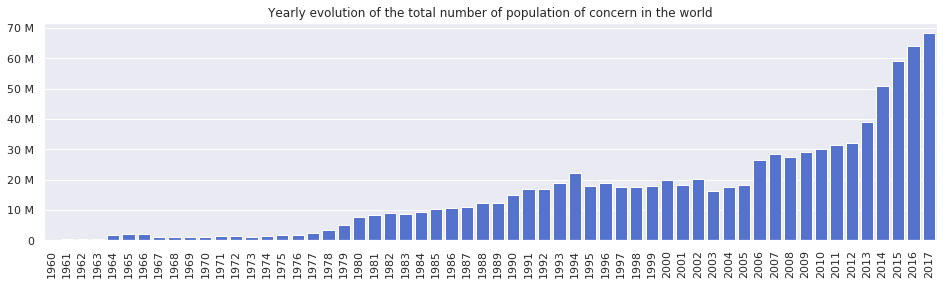

In [30]:
plt.figure(figsize=(16,4))
ax = sns.barplot(x=[data['year'] for data in out_total_pop], 
                 y=[data['affectedTotal'] for data in out_total_pop],
                 color='royalblue')
ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.xticks(rotation='vertical')
plt.title("Yearly evolution of the total number of population of concern in the world");

### Countries with the highest/lowest accumulated total number of people of concern residing_in/originating_from through the years

Define a query that creates a subgraph with data from a certain year and sums the property value affected_total of all relationships that exit/enter (originate_from/reside_in) a node, and orders by this value in descending mode returning the country, the total and total_affected summed value of the firstfive results:

In [31]:
def top_total_reside_in(tx, year, top_number, desc_flag):
    return tx.run("MATCH (a:CountryYear)<-[r:RESIDE_IN]-() "
                         "WHERE a.year={0} " 
                         "RETURN a.country as country, a.year as year, sum(r.affected_total) as affectedTotal, sum(r.affected_refugees) as affectedRefugees "
                         "ORDER BY affectedTotal {2} LIMIT {1} ".format(year, top_number, desc_flag)) 

In [32]:
def top_total_originate_from(tx, year, top_number, desc_flag):
    return tx.run("MATCH (a:CountryYear)-[r:RESIDE_IN]->() "
                         "WHERE a.year={0} " 
                         "RETURN a.country as country, a.year as year, sum(r.affected_total) as affectedTotal, sum(r.affected_refugees) as affectedRefugees "
                         "ORDER BY affectedTotal {2} LIMIT {1} ".format(year, top_number, desc_flag))


Execute queries on Neo4j and store results in python list:

In [33]:
top_number_limit_C1 = 3
top_number_limit_C2 = 1

In [34]:
with driver.session() as session:
    out_residing_highest = []
    out_originating_highest = []
    out_residing_lowest = []
    out_originating_lowest = []
    for year in years_list[0::1]:
        [out_residing_highest.append(element) for element in session.read_transaction(top_total_reside_in, year, top_number_limit_C1, "DESC").data()]
        [out_originating_highest.append(element) for element in session.read_transaction(top_total_originate_from, year, top_number_limit_C1, "DESC").data()]
        [out_residing_lowest.append(element) for element in session.read_transaction(top_total_reside_in, year, top_number_limit_C2, "").data()]
        [out_originating_lowest.append(element) for element in session.read_transaction(top_total_originate_from, year, top_number_limit_C2, "").data()]

Define ploting functions:

In [35]:
def plot_top_total_countries(data_list, rel_type, top_number_limit ):
    plt.figure(figsize=(14,9))
    ax = sns.scatterplot(x=[data['year'] for data in data_list], 
                         y=[data['affectedTotal'] for data in data_list], 
                         hue=[data['country'] for data in data_list],
                         size=[data['affectedRefugees'] for data in data_list],
                         sizes=(20, 200))
    ax.set_title("Top {0} countries where the highest number of population of concern have {1} through the years.\n " 
                 "Size of buble represents the number of refugees".format(top_number_limit, rel_type))
    ax.set_ylabel('Affected Total')
    ax.set_xlabel('Year')
    ax.yaxis.set_major_formatter(ticker.EngFormatter())

In [60]:
def plot_country_lowest_total(data_list, rel_type):
    plt.figure(figsize=(16,4))
    ax = sns.barplot(x=[data['country-year'] for data in data_list], 
                     y=[data['affectedTotal'] for data in data_list],
                     color='forestgreen')
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set(ylim=(0, 100))
    plt.xticks(rotation='vertical')
    plt.title("Country with the least number of people of concern {0} it for every given year".format(rel_type));

 - Countries with the highest number of population of concern Resisding in them:

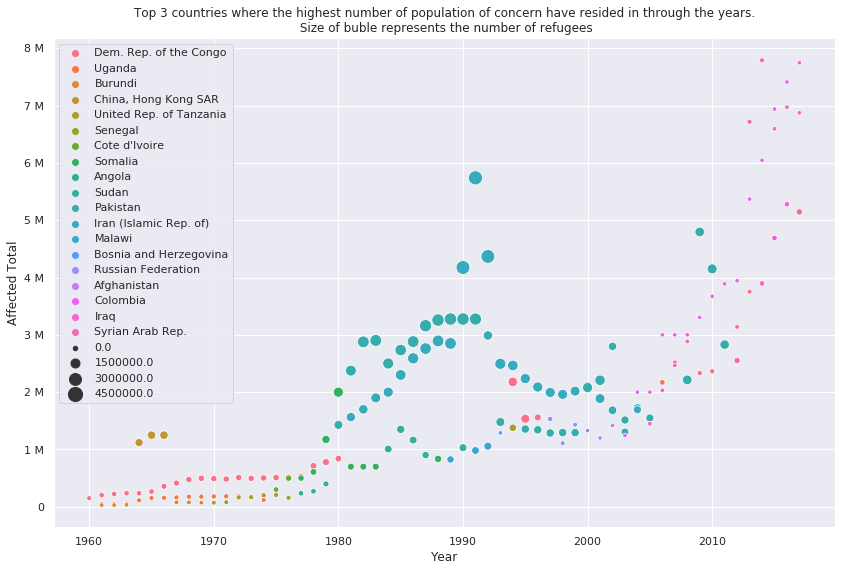

In [36]:
plot_top_total_countries(out_residing_highest, "resided in", top_number_limit_C1 )

 - Countries with the highest number of population of concern Originating from them:

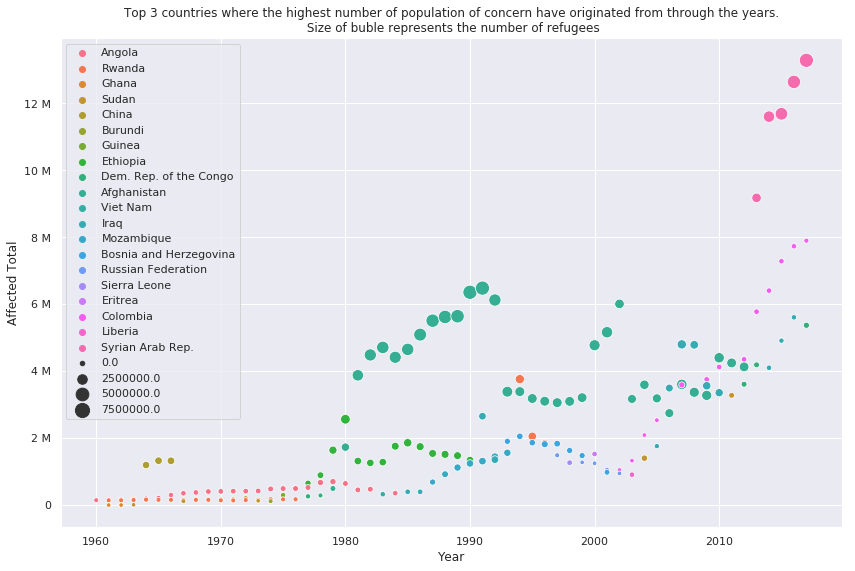

In [37]:
plot_top_total_countries(out_originating_highest, "originated from", top_number_limit_C1 )

 - Countries with the lowest number of population of concern Resisding in them:

In [61]:
out_residing_lowest_modified = [dict(data, **{'country-year':data['country'] + str(data['year'])}) for data in out_residing_lowest]

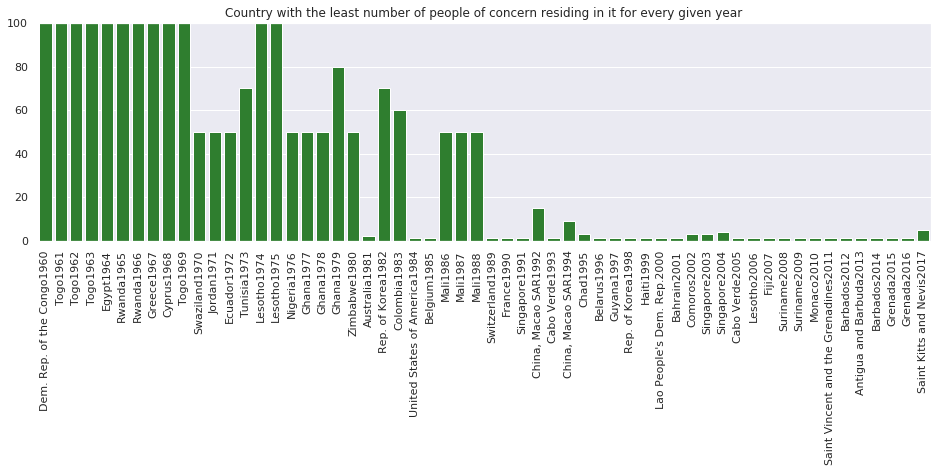

In [63]:
plot_country_lowest_total(out_residing_lowest_modified, "residing in")

 - Countries with the highest number of population of concern Originating from them:

In [55]:
out_originating_lowest_modified = [dict(data, **{'country-year':data['country'] + str(data['year'])}) for data in out_originating_lowest]

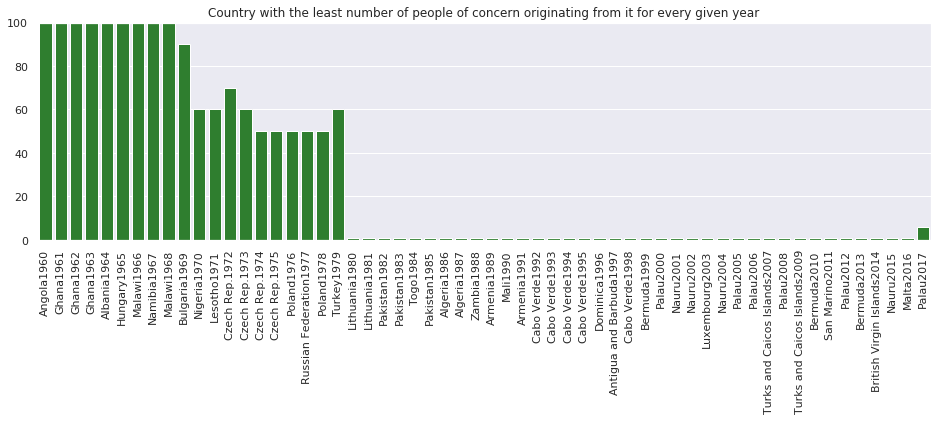

In [64]:
plot_country_lowest_total(out_originating_lowest_modified, "originating from")

### Analyse refugees and asylum seekes figures for one particular country in a given a given year

 - Given year and country of residence, obtain the number of people that request asylum and their country of origin:

In [73]:
def origin_countries_given_residence_and_year(tx,year,country_residence):
    return tx.run("MATCH (a:CountryYear)<-[r:RESIDE_IN]-(b:CountryYear) "
                         "WHERE a.year={0} AND a.country={1} " 
                         "RETURN b.country AS country, "                         
                         "r.affected_refugees AS affectedRefugees, "
                         "r.affected_asylum AS affectedAsylum, "
                         "r.affected_total AS affectedTotal "
                         "ORDER BY affectedTotal DESC"
                  .format(year,country_residence))

 - Given year and country of origin, obtain the number of people that request asylum and their country of residence:

In [74]:
def origin_countries_given_origin_and_year(tx,year,country_origin):
    return tx.run("MATCH (a:CountryYear)-[r:RESIDE_IN]->(b:CountryYear) "
                         "WHERE a.year={0} AND a.country={1} " 
                         "RETURN b.country as country, "
                         "r.affected_refugees AS affectedRefugees, "
                         "r.affected_asylum AS affectedAsylum, "
                         "r.affected_total AS affectedTotal "
                         "ORDER BY affectedTotal DESC".format(year,country_origin))

Calling both previous functions and ploting results for a year/country:

In [79]:
country_C2 = '"Spain"'
year_C2 = 2017
limit_C2 = 10

In [76]:
with driver.session() as session:
    countries_given_residence = session.read_transaction(origin_countries_given_residence_and_year, year_C2, country_C2).data()
    countries_given_origin = session.read_transaction(origin_countries_given_origin_and_year, year_C2, country_C2).data()

Remove None and turn into 0 for ploting:

In [86]:
def plot_country_difference_refugees_and_assylum_seekers(data_list, limit, country, year, rel_type):

    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(13)
    ax.stackplot([data['country'] for data in data_list][0:limit], 
                 [int(data['affectedAsylum'] or 0) for data in data_list][0:limit], 
                 [int(data['affectedRefugees'] or 0) for data in data_list][0:limit])
    plt.xticks(rotation='vertical')
    plt.legend(('affectedAsylum', 'affectedRefugees'))
    plt.title("Countries of {2} with {0} as country of {3} for year {1}".format(country, year, rel_type.split('/')[0], rel_type.split('/')[1]))
    plt.show()

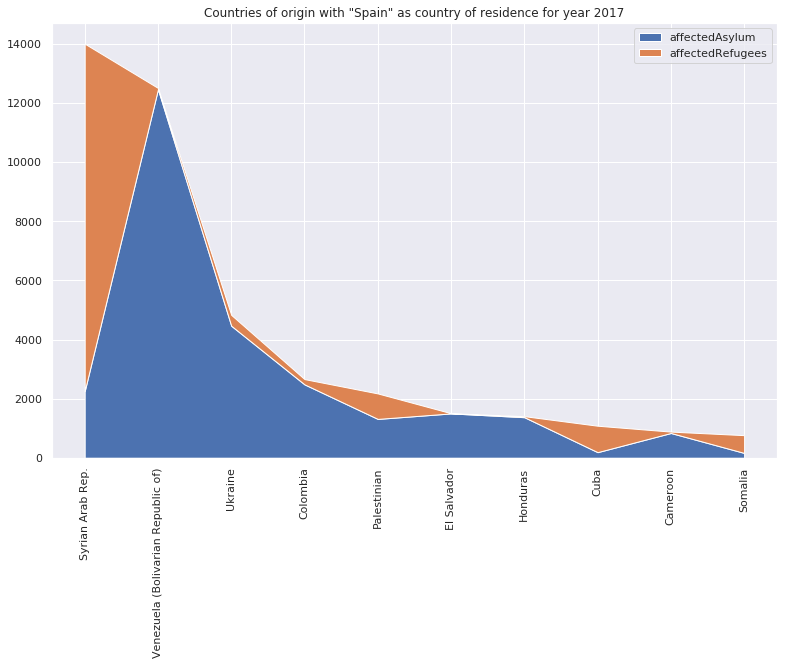

In [87]:
plot_country_difference_refugees_and_assylum_seekers(countries_given_residence, limit_C2, country_C2, year_C2, "origin/residence" )

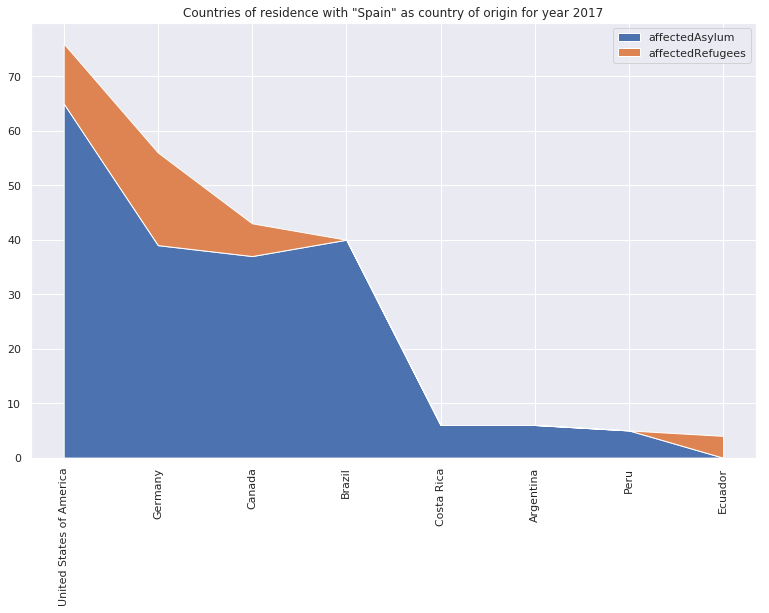

In [88]:
plot_country_difference_refugees_and_assylum_seekers(countries_given_origin, limit_C2, country_C2, year_C2, "residence/origin" )

## Testing how to Export a subgraph to different formats

In [18]:
def export_graph(tx,format_of_export, country, year):
    return tx.run("CALL apoc.export.{0}.query( "
                  "'MATCH p=()<-[r:RESIDE_IN]-(n) WHERE n.year={2} AND n.country={1} RETURN p', " 
                  "'../neo4j/import/prueba.{0}', {{}} )".format(format_of_export, country, year))

to graphml

In [19]:
with driver.session() as session:
    session.read_transaction(export_graph, "graphml", '"Spain"', "2017")

to json

In [20]:
with driver.session() as session:
    session.read_transaction(export_graph, "json",'"Spain"', "2017")